## K Nearest Neighbors (KNN) — End-to-End Workflow

This notebook walks through a full supervised learning pipeline for KNN:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: train/test split, feature scaling (critical for distance-based models)
	•	Modeling: from-scratch SimpleKNNClassifier and scikit-learn KNeighborsClassifier, plus hyperparameter tuning
	•	Evaluation: accuracy, confusion matrix, classification report, ROC-AUC (OvR), k-selection curve

Why KNN? A simple, non-parametric, instance-based learner that classifies a sample by the majority (or distance-weighted) vote of its k nearest neighbors.

## Setup

We’ll use the Wine dataset (multiclass classification, numeric features). KNN depends on distances → always scale features.

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, List, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.5, 4.0)

## Data Exploration

We’ll load Wine, inspect shape and stats, check class balance, and (optionally) view quick pairwise structure.

Shape: (178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000



Class counts (0,1,2):


target
1    71
0    59
2    48
Name: count, dtype: int64

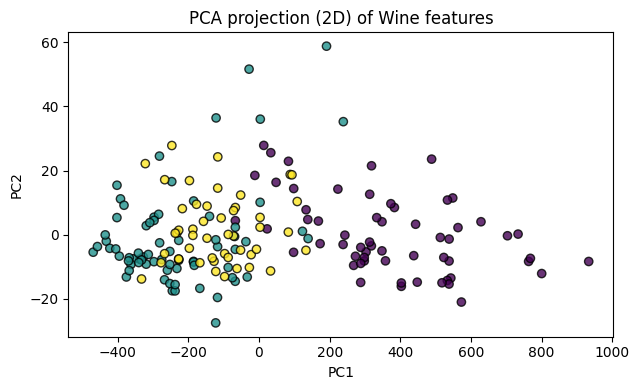

In [2]:
# Load Wine dataset
wine = load_wine(as_frame=True)
X: pd.DataFrame = wine.data.copy()
y: pd.Series = pd.Series(wine.target, name="target")  # classes: 0,1,2

df = X.copy()
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

print("\nClass counts (0,1,2):")
display(y.value_counts())

# Optional overview via PCA (2D projection)
pca = PCA(n_components=2, random_state=42)
X_p2 = pca.fit_transform(X)
plt.scatter(X_p2[:,0], X_p2[:,1], c=y, edgecolor="k", alpha=0.8)
plt.title("PCA projection (2D) of Wine features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

## Preprocessing
	•	Stratified train/test split
	•	Standardize features (StandardScaler) — KNN is distance-based, so scaling matters

In [3]:
# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class proportions:\n", y_train.value_counts(normalize=True))

Train shape: (133, 13)  Test shape: (45, 13)
Train class proportions:
 target
1    0.398496
0    0.330827
2    0.270677
Name: proportion, dtype: float64


## Modeling

We’ll train:
	1.	From-scratch KNN (Euclidean distance; uniform or distance weighting)
	2.	scikit-learn KNN in a pipeline with scaling
We’ll also tune k, weights, and metric with GridSearchCV.

In [4]:
class SimpleKNNClassifier:
    """
    Minimal KNN classifier
    - Euclidean distance
    - weights: 'uniform' (majority vote) or 'distance' (1 / (d + eps))
    - Stores training data (lazy learner)
    """
    def __init__(self, n_neighbors: int = 5, weights: str = "uniform", eps: float = 1e-12):
        assert n_neighbors >= 1
        assert weights in ("uniform", "distance")
        self.n_neighbors = int(n_neighbors)
        self.weights = weights
        self.eps = float(eps)
        self.X_: Optional[np.ndarray] = None
        self.y_: Optional[np.ndarray] = None
        self.classes_: Optional[np.ndarray] = None

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.Series, np.ndarray]):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def _distances(self, x: np.ndarray) -> np.ndarray:
        # Euclidean distances to all training points (vectorized)
        # ||X - x|| across rows
        diff = self.X_ - x
        return np.sqrt(np.sum(diff * diff, axis=1))

    def _vote(self, idx: np.ndarray, dists: np.ndarray) -> int:
        # Uniform: count labels; Distance: weight by 1/(d+eps)
        labels = self.y_[idx]
        if self.weights == "uniform":
            # majority vote; tie-break by smallest class id
            counts = {c: 0.0 for c in self.classes_}
            for lab in labels:
                counts[lab] += 1.0
        else:
            # distance-weighted vote
            counts = {c: 0.0 for c in self.classes_}
            nn_d = dists[idx]
            w = 1.0 / (nn_d + self.eps)
            for lab, wv in zip(labels, w):
                counts[lab] += wv

        # return argmax with deterministic tie-break
        best_lab = None
        best_val = -np.inf
        for c in sorted(self.classes_):  # sort ensures deterministic tie-break to smaller class id
            if counts[c] > best_val:
                best_val = counts[c]
                best_lab = c
        return int(best_lab)

    def _proba(self, idx: np.ndarray, dists: np.ndarray) -> np.ndarray:
        # Probability estimate by normalized (uniform or distance) weights
        labels = self.y_[idx]
        if self.weights == "uniform":
            w = np.ones_like(idx, dtype=float)
        else:
            nn_d = dists[idx]
            w = 1.0 / (nn_d + self.eps)

        # sum weights per class
        sums = np.zeros(len(self.classes_), dtype=float)
        class_to_pos = {c: j for j, c in enumerate(self.classes_)}
        for lab, wv in zip(labels, w):
            sums[class_to_pos[lab]] += wv

        if sums.sum() == 0:
            # fallback uniform if all zero (should not really happen)
            return np.ones_like(sums) / len(sums)
        return sums / sums.sum()

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        preds = []
        for i in range(X.shape[0]):
            d = self._distances(X[i])
            nn_idx = np.argsort(d)[: self.n_neighbors]
            preds.append(self._vote(nn_idx, d))
        return np.array(preds, dtype=int)

    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        probs = []
        for i in range(X.shape[0]):
            d = self._distances(X[i])
            nn_idx = np.argsort(d)[: self.n_neighbors]
            probs.append(self._proba(nn_idx, d))
        return np.vstack(probs)

In [5]:
# Build BOTH models, with proper scaling
# 1) From-scratch path: fit scaler, transform arrays, then SimpleKNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

knn_simple = SimpleKNNClassifier(n_neighbors=5, weights="uniform")
knn_simple.fit(X_train_scaled, y_train)

# 2) sklearn KNN in a Pipeline (recommended for production)
knn_sklearn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="uniform", metric="minkowski", p=2))
])
knn_sklearn.fit(X_train, y_train)

,steps,"[('scaler', ...), ('knn', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


## Hyperparameter Tuning

We’ll tune n_neighbors, weights, and metric with 5-fold Stratified CV on the sklearn pipeline.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],  # (p=1 manhattan, p=2 euclidean); you can add "chebyshev" etc.
    "knn__p": [1, 2],
}

grid = GridSearchCV(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier())
    ]),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)
knn_best = grid.best_estimator_

Best params: {'knn__metric': 'minkowski', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV accuracy: 0.9925925925925926


## Evaluation

We’ll compute accuracy, confusion matrices, classification reports, and multi-class ROC-AUC (OvR).
We’ll also draw a simple k-selection curve to visualize the effect of n_neighbors.

In [7]:
def evaluate_multiclass(name: str, model, X_te, y_te, label_names=None):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)

    # Try to get class probabilities for macro ROC-AUC (OvR)
    auc = np.nan
    try:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_te)
        else:
            # fall back: if this is the simple KNN used with pre-scaled arrays
            # wrap to supply predict_proba
            proba = None
        if proba is not None:
            auc = roc_auc_score(y_te, proba, multi_class="ovr", average="macro")
    except Exception:
        pass

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro ROC-AUC (OvR): {auc if not np.isnan(auc) else 'N/A'}")
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification report:\n", classification_report(y_te, y_pred, target_names=label_names))
    return acc, auc

# Evaluate from-scratch (note: we must pass scaled arrays)
acc_simple, auc_simple = evaluate_multiclass(
    "SimpleKNN (from-scratch, scaled)", knn_simple, X_test_scaled, y_test, wine.target_names
)

# Evaluate sklearn baseline
acc_sk, auc_sk = evaluate_multiclass(
    "KNeighbors (sklearn)", knn_sklearn, X_test, y_test, wine.target_names
)

# Evaluate tuned model
acc_best, auc_best = evaluate_multiclass(
    "KNeighbors (tuned)", knn_best, X_test, y_test, wine.target_names
)


=== SimpleKNN (from-scratch, scaled) ===
Accuracy: 0.9333 | Macro ROC-AUC (OvR): 0.9932815812445442
Confusion matrix:
 [[15  0  0]
 [ 0 16  2]
 [ 0  1 11]]
Classification report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        15
     class_1       0.94      0.89      0.91        18
     class_2       0.85      0.92      0.88        12

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45


=== KNeighbors (sklearn) ===
Accuracy: 0.9333 | Macro ROC-AUC (OvR): 0.9932815812445442
Confusion matrix:
 [[15  0  0]
 [ 0 16  2]
 [ 0  1 11]]
Classification report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        15
     class_1       0.94      0.89      0.91        18
     class_2       0.85      0.92      0.88        12

    accuracy                           0.93        

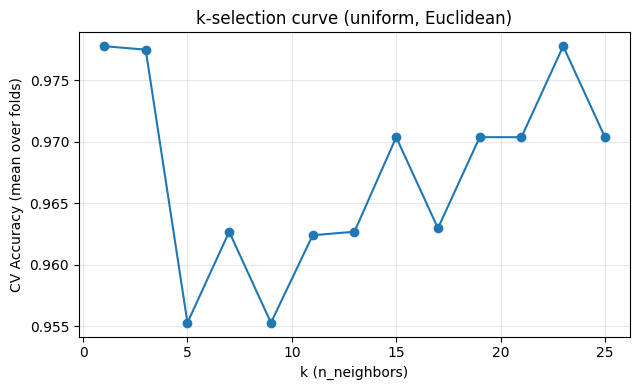

In [8]:
# k-selection curve with cross-validation (on pipeline)
k_values = list(range(1, 26, 2))  # odd k to reduce ties
cv_scores = []
pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])

for k in k_values:
    pipe.set_params(knn__n_neighbors=k, knn__weights="uniform", knn__metric="minkowski", knn__p=2)
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores, marker="o")
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV Accuracy (mean over folds)")
plt.title("k-selection curve (uniform, Euclidean)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Key Takeaways
	•	KNN is a lazy, non-parametric learner: “training” just stores the data; prediction is distance-based lookup.
	•	Scaling is essential — feature magnitudes define distances.
	•	Hyperparameters to tune:
	•	n_neighbors (k): typically odd numbers for binary; search grid or elbow curve
	•	weights: "uniform" vs "distance"
	•	metric & p: Euclidean (p=2), Manhattan (p=1), etc.
	•	Complexity: prediction is O(n \cdot d) per query (n = train size, d = features). Use indexing (KD-trees/ball trees) or approximate methods for large n.
	•	Strengths: simple, competitive with good scaling and k-choice, handles multi-class naturally.
	•	Weaknesses: slow at inference for large datasets; sensitive to irrelevant features and scale.